In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk
from imblearn.over_sampling import RandomOverSampler

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Before oversampling:
Number of 'False' samples: 2850
Number of 'True' samples: 483

After oversampling:
Number of 'False' samples: 2850
Number of 'True' samples: 2850

Number of rows in training set: 3990
Number of rows in test set: 1710

Top 10 Features based on Importance:
                Feature  Importance
3595      Intl_Plan_yes    0.008939
13249  CustServ_Calls_4    0.005312
13066      Intl_Calls_2    0.003798
13250  CustServ_Calls_5    0.003141
13251  CustServ_Calls_6    0.001117
30             State_NJ    0.001033
13067      Intl_Calls_3    0.001018
19             State_MD    0.000865
13202  Intl_Charge_3.75    0.000864
13021    Intl_Mins_13.9    0.000864

Features with Importance Greater than 0.005:
                Feature  Importance
3595      Intl_Plan_yes    0.008939
13249  CustServ_Calls_4    0.005312

Confusion Matrix for Training Set:
[[1936   59]
 [   9 1986]]


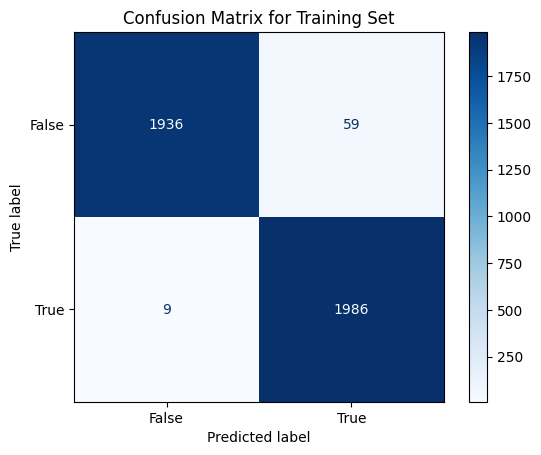


Metrics for Training Set:
Accuracy: 0.9830
Sensitivity: 0.9955
Specificity: 0.9704
Precision: 0.9711
F-measure: 0.9832

Confusion Matrix for Test Set:
[[671 184]
 [ 19 836]]


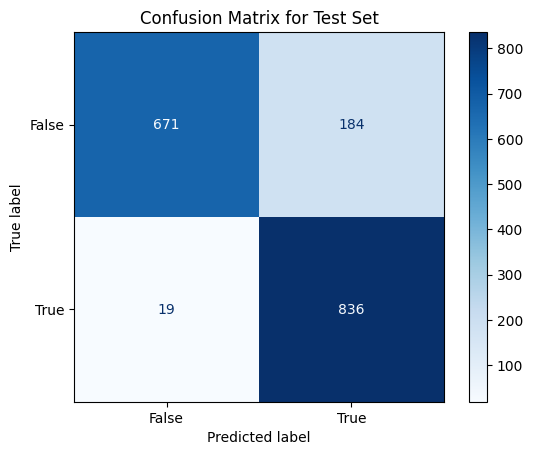


Metrics for Test Set:
Accuracy: 0.8813
Sensitivity: 0.9778
Specificity: 0.7848
Precision: 0.8196
F-measure: 0.8917


In [ ]:
#ALL ATTRIBUTES

import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load the churn dataset
data = pd.read_csv('/content/churn.csv')

# Rename columns with special characters
data.rename(columns={
    'Churn?': 'Churn',
    'Int\'l Plan': 'Intl_Plan',
    'VMail Plan': 'VMail_Plan',
    'Account Length': 'Account_Length',
    'Area Code': 'Area_Code',
    'VMail Message': 'VMail_Message',
    'Day Mins': 'Day_Mins',
    'Day Calls': 'Day_Calls',
    'Day Charge': 'Day_Charge',
    'Eve Mins': 'Eve_Mins',
    'Eve Calls': 'Eve_Calls',
    'Eve Charge': 'Eve_Charge',
    'Night Mins': 'Night_Mins',
    'Night Calls': 'Night_Calls',
    'Night Charge': 'Night_Charge',
    'Intl Mins': 'Intl_Mins',
    'Intl Calls': 'Intl_Calls',
    'Intl Charge': 'Intl_Charge',
    'CustServ Calls': 'CustServ_Calls'
}, inplace=True)

# Convert target variable to boolean
data['Churn'] = data['Churn'].apply(lambda x: True if x == 'True.' else False)

# Define relevant attributes for processing
attributes = data[['State', 'Account_Length', 'Area_Code', 'Phone', 'Intl_Plan', 'VMail_Plan',
                   'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls',
                   'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins',
                   'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Churn']]

# Encode categorical features using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_features = encoder.fit_transform(attributes.drop(columns=['Churn']))
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Add the target variable
encoded_df['Churn'] = attributes['Churn'].values

# Step 1: Separate majority ('False') and minority ('True') classes
df_majority = encoded_df[encoded_df['Churn'] == False]
df_minority = encoded_df[encoded_df['Churn'] == True]

# Print class distribution before oversampling
print("Before oversampling:")
print("Number of 'False' samples:", df_majority.shape[0])
print("Number of 'True' samples:", df_minority.shape[0])

# Step 2: Oversample the minority class ('True') to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(encoded_df.drop(columns=['Churn']), encoded_df['Churn'])

# Create balanced DataFrame using concatenation
balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=encoded_df.drop(columns=['Churn']).columns),
                           pd.DataFrame(y_resampled, columns=['Churn'])], axis=1)

# Print class distribution after oversampling
df_majority_balanced = balanced_data[balanced_data['Churn'] == False]
df_minority_balanced = balanced_data[balanced_data['Churn'] == True]
print("\nAfter oversampling:")
print("Number of 'False' samples:", df_majority_balanced.shape[0])
print("Number of 'True' samples:", df_minority_balanced.shape[0])

# Step 3: Split into training (70%) and testing (30%) datasets
X = balanced_data.drop(columns=['Churn'])
y = balanced_data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print number of rows in training and test sets
print("\nNumber of rows in training set:", X_train.shape[0])
print("Number of rows in test set:", X_test.shape[0])

# Initialize and train Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Get feature log probabilities (log likelihood of each feature given each class)
feature_log_probs = nb.feature_log_prob_

# Convert log probabilities to regular probabilities for easier interpretation
feature_probs = np.exp(feature_log_probs)

# Calculate importance based on difference in probabilities between classes
importance = feature_probs[1] - feature_probs[0]  # Importance for the 'True' class

# Create a DataFrame to show feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Print only top N important features
top_n = 10  # Number of top features to display
print(f"\nTop {top_n} Features based on Importance:")
print(importance_df.head(top_n))

# Alternatively, print features with importance greater than a certain threshold
threshold = 0.005  # Define your threshold value
print(f"\nFeatures with Importance Greater than {threshold}:")
print(importance_df[importance_df['Importance'] > threshold])

# Confusion Matrix for Training Set
print("\nConfusion Matrix for Training Set:")
cm_train = confusion_matrix(y_train, nb.predict(X_train), labels=[False, True])
print(cm_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[False, True])
disp_train.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Calculate and print metrics for training set
def calculate_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f_measure = 2 * (precision * sensitivity) / (precision + sensitivity)
    return accuracy, sensitivity, specificity, precision, f_measure

accuracy_train, sensitivity_train, specificity_train, precision_train, f_measure_train = calculate_metrics(cm_train)
print("\nMetrics for Training Set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Sensitivity: {sensitivity_train:.4f}")
print(f"Specificity: {specificity_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"F-measure: {f_measure_train:.4f}")

# Confusion Matrix for Test Set
print("\nConfusion Matrix for Test Set:")
cm_test = confusion_matrix(y_test, nb.predict(X_test), labels=[False, True])
print(cm_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[False, True])
disp_test.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Calculate and print metrics for test set
accuracy_test, sensitivity_test, specificity_test, precision_test, f_measure_test = calculate_metrics(cm_test)
print("\nMetrics for Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Sensitivity: {sensitivity_test:.4f}")
print(f"Specificity: {specificity_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"F-measure: {f_measure_test:.4f}")

Before oversampling:
Number of 'False' samples: 2850
Number of 'True' samples: 483

After oversampling:
Number of 'False' samples: 2850
Number of 'True' samples: 2850

Number of rows in training set: 3990
Number of rows in test set: 1710

Top 10 Features based on Importance:
                Feature  Importance
3382      Intl_Plan_yes    0.009748
13035  CustServ_Calls_4    0.005794
12852      Intl_Calls_2    0.004111
13036  CustServ_Calls_5    0.003428
13037  CustServ_Calls_6    0.001220
30             State_NJ    0.001123
12853      Intl_Calls_3    0.001058
12988  Intl_Charge_3.75    0.000944
12807    Intl_Mins_13.9    0.000944
19             State_MD    0.000939

Features with Importance Greater than 0.005:
                Feature  Importance
3382      Intl_Plan_yes    0.009748
13035  CustServ_Calls_4    0.005794

Confusion Matrix for Training Set:
[[1939   56]
 [   7 1988]]


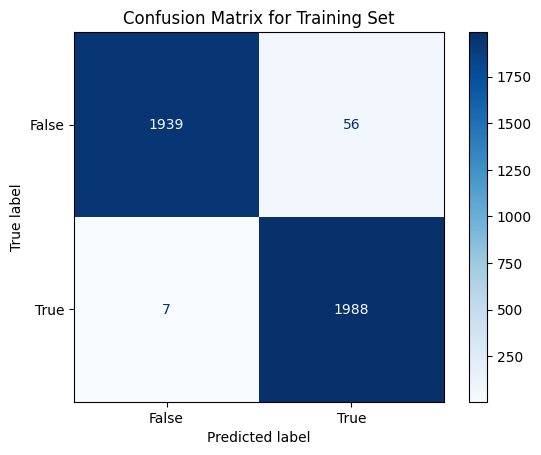


Metrics for Training Set:
Accuracy: 0.9842
Sensitivity: 0.9965
Specificity: 0.9719
Precision: 0.9726
F-measure: 0.9844

Confusion Matrix for Test Set:
[[673 182]
 [ 14 841]]


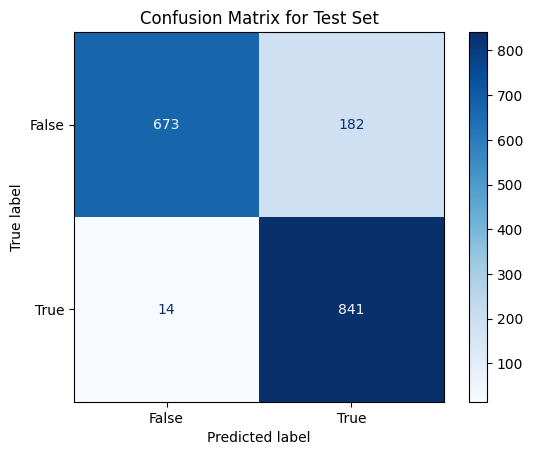


Metrics for Test Set:
Accuracy: 0.8854
Sensitivity: 0.9836
Specificity: 0.7871
Precision: 0.8221
F-measure: 0.8956


In [ ]:
#SELECTED ATTRIBUTES - Area_Code & Account_Length & VMail_Plan out

import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load the churn dataset
data = pd.read_csv('/content/churn.csv')

# Rename columns with special characters
data.rename(columns={
    'Churn?': 'Churn',
    'Int\'l Plan': 'Intl_Plan',
    'VMail Plan': 'VMail_Plan',
    'Account Length': 'Account_Length',
    'Area Code': 'Area_Code',
    'VMail Message': 'VMail_Message',
    'Day Mins': 'Day_Mins',
    'Day Calls': 'Day_Calls',
    'Day Charge': 'Day_Charge',
    'Eve Mins': 'Eve_Mins',
    'Eve Calls': 'Eve_Calls',
    'Eve Charge': 'Eve_Charge',
    'Night Mins': 'Night_Mins',
    'Night Calls': 'Night_Calls',
    'Night Charge': 'Night_Charge',
    'Intl Mins': 'Intl_Mins',
    'Intl Calls': 'Intl_Calls',
    'Intl Charge': 'Intl_Charge',
    'CustServ Calls': 'CustServ_Calls'
}, inplace=True)

# Convert target variable to boolean
data['Churn'] = data['Churn'].apply(lambda x: True if x == 'True.' else False)

# Define relevant attributes for processing
attributes = data[['State', 'Phone', 'Intl_Plan',
                   'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls',
                   'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins',
                   'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Churn']]

# Encode categorical features using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_features = encoder.fit_transform(attributes.drop(columns=['Churn']))
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Add the target variable
encoded_df['Churn'] = attributes['Churn'].values

# Step 1: Separate majority ('False') and minority ('True') classes
df_majority = encoded_df[encoded_df['Churn'] == False]
df_minority = encoded_df[encoded_df['Churn'] == True]

# Print class distribution before oversampling
print("Before oversampling:")
print("Number of 'False' samples:", df_majority.shape[0])
print("Number of 'True' samples:", df_minority.shape[0])

# Step 2: Oversample the minority class ('True') to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(encoded_df.drop(columns=['Churn']), encoded_df['Churn'])

# Create balanced DataFrame using concatenation
balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=encoded_df.drop(columns=['Churn']).columns),
                           pd.DataFrame(y_resampled, columns=['Churn'])], axis=1)

# Print class distribution after oversampling
df_majority_balanced = balanced_data[balanced_data['Churn'] == False]
df_minority_balanced = balanced_data[balanced_data['Churn'] == True]
print("\nAfter oversampling:")
print("Number of 'False' samples:", df_majority_balanced.shape[0])
print("Number of 'True' samples:", df_minority_balanced.shape[0])

# Step 3: Split into training (70%) and testing (30%) datasets
X = balanced_data.drop(columns=['Churn'])
y = balanced_data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print number of rows in training and test sets
print("\nNumber of rows in training set:", X_train.shape[0])
print("Number of rows in test set:", X_test.shape[0])

# Initialize and train Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Get feature log probabilities (log likelihood of each feature given each class)
feature_log_probs = nb.feature_log_prob_

# Convert log probabilities to regular probabilities for easier interpretation
feature_probs = np.exp(feature_log_probs)

# Calculate importance based on difference in probabilities between classes
importance = feature_probs[1] - feature_probs[0]  # Importance for the 'True' class

# Create a DataFrame to show feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Print only top N important features
top_n = 10  # Number of top features to display
print(f"\nTop {top_n} Features based on Importance:")
print(importance_df.head(top_n))

# Alternatively, print features with importance greater than a certain threshold
threshold = 0.005  # Define your threshold value
print(f"\nFeatures with Importance Greater than {threshold}:")
print(importance_df[importance_df['Importance'] > threshold])

# Confusion Matrix for Training Set
print("\nConfusion Matrix for Training Set:")
cm_train = confusion_matrix(y_train, nb.predict(X_train), labels=[False, True])
print(cm_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[False, True])
disp_train.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Calculate and print metrics for training set
def calculate_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f_measure = 2 * (precision * sensitivity) / (precision + sensitivity)
    return accuracy, sensitivity, specificity, precision, f_measure

accuracy_train, sensitivity_train, specificity_train, precision_train, f_measure_train = calculate_metrics(cm_train)
print("\nMetrics for Training Set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Sensitivity: {sensitivity_train:.4f}")
print(f"Specificity: {specificity_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"F-measure: {f_measure_train:.4f}")

# Confusion Matrix for Test Set
print("\nConfusion Matrix for Test Set:")
cm_test = confusion_matrix(y_test, nb.predict(X_test), labels=[False, True])
print(cm_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[False, True])
disp_test.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Calculate and print metrics for test set
accuracy_test, sensitivity_test, specificity_test, precision_test, f_measure_test = calculate_metrics(cm_test)
print("\nMetrics for Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Sensitivity: {sensitivity_test:.4f}")
print(f"Specificity: {specificity_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"F-measure: {f_measure_test:.4f}")